In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
import scipy.signal as sig
import time

The goal of this ntoebook is to document, test, and demonstrate advanced methods of estimating the time delay between two signals in the presence of noise and other disturbances. This document begins with a simple, naive least-squares regression and grows in sohpistication until we are using powerful, built-in (and black-box) functions in scipy.

In [3]:
# An algorithm for creating pink noise 
# From Allen Downey's notes here:
# https://www.dsprelated.com/showarticle/908.php
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

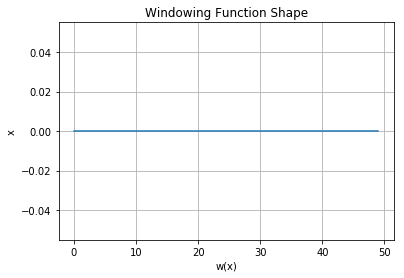

In [4]:
# Windowing function to taper the signals to 0 at the ends to minimize
# edge effects on frequencies. Documentation can be found in the scipy
# library documentation
def windowFun(xs):
    l = len(xs)
    # maybe define this a-priori to increase run-speed
    w = sig.windows.hann(l)
    a = np.dot(xs,w)/sum(w)
    return (xs-a) * w

    #return xs * sig.windows.hamming(l)

def windowFast(xs,w):
    #l = len(xs)
    # maybe define this a-priori to increase run-speed
    #w = sig.windows.hann(l)
    a = np.dot(xs,w)/sum(w)
    return (xs-a) * w

    #return xs * sig.windows.hamming(l)
if 1:
    plt.plot(windowFun(np.ones(50)))
    plt.title('Windowing Function Shape')
    plt.xlabel('w(x)')
    plt.ylabel('x')
    plt.grid()

## Time to make the signal and test it

In [5]:
# create the simulated signals
samplingRate = 10   # hz
dT = 1/samplingRate # sec
tf = 150
n = tf/dT+1

ts = np.arange(start=0,stop=tf,step=dT)

dt = 300 # We are setting the time delay to be 300 steps
l = 1000
start = 0

# Create the simulated data sets for the sensor signals
u = voss(len(ts))
v = voss(len(ts))
S1 = u[ (start+dt) : (start+dt+l) ]
S2 = u[ start:(start+l) ]
t = ts[ :l]

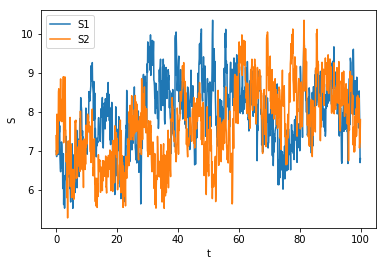

In [6]:
# plot the two signals. Note that events reach S1 before they reach S2
plt.plot(t,S1)
plt.plot(t,S2)
plt.xlabel('t')
plt.ylabel('S')
plt.legend(['S1','S2'])
plt.show()

In [7]:
# compute means and center the data
S1m = sum(S1)/len(S1)
S2m = sum(S2)/len(S2)
print(S1m)
print(S2m)
s1 = S1-S1m
#s1t = S1t-S1m
s2 = S2-S2m

7.93014771771228
7.671714524830035


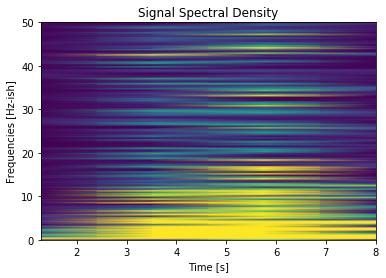

In [20]:
f, t, Sxx = sig.spectrogram(windowFun(s2), 100)
nor = mpl.colors.Normalize(vmin=0, vmax=.007, clip=False)
plt.pcolormesh(t, f, Sxx, shading='gouraud',norm=nor)
plt.title('Signal Spectral Density')
plt.ylabel('Frequencies [Hz-ish]')
plt.xlabel('Time [s]')
plt.show()

from: https://www.ee.columbia.edu/~dpwe/papers/LinLee06-brand.pdf Some sentences are taken directly from the test of this paper.

We are seeking the minimum of the conventional linear deconvolution function:

$\min_{\mathbf{\alpha}}||s_2-\mathbf{S_1\alpha}||^2$

Where $s_2$ is vector containing the dicrete time-series data for the downstream sensor. $\mathbf{S_1}$ is a NxM matrix where each column of $\mathbf{S}$ is a time-shifted vector of the $s_1$ data (going up to lagRange). If N > M (meaning that lagRange is less than the length of the data), then the matrix optimization can be done using the pseudo-inverse:

To think about this intuitively, $\alpha_i$ will be largest when the downstream signal, $s_2$ lines up with the correctly time-shifted row of $s_1$ values in the matrix $\mathbf{S_1}$

This problem is now formulated in a classic least-squares way

$\alpha=(\mathbf{S_1}^T\mathbf{S_1})^{-1}\mathbf{S_1}^Ts_2$



Adding a L2 norm,

$\lambda||\alpha||^2$

the resulting optimizaiton problem becomes:

$\alpha=(\mathbf{S}^T\mathbf{S}+\lambda n \mathbf{I})^{-1}\mathbf{S}^Tx$

Regularization with the L2 norm is nice and easy because it is readily differientiable. However, L2 regularization still does not eliminate terms. L1 regularizaiton does. This paper uses an interated ridge-regression variation to perform Lasso regularization. The appropriate reference is in the function below.

The final function that is used, and the most promising candidate is Non-negative Least Squares (nnls). The benefits are described in https://www.ee.columbia.edu/~dpwe/papers/LinLee06-brand.pdf  in great detail. The implementation in the paper uses a Bayesian Prior to regularize on the regression. That prior is not implemented in the code below, but could further improve functionality.

In [7]:
# returns the time delay between s1 and s2 
# (positive means that s2 receives the signal after s1)
# Method: 'nnls', 'ridge', 'lasso'
# lam = regularization parameter
# fast should be a scipy.signal.window object
def nndecon(s1, s2, method='nnls', lam=0,window=False,scale=True,fast=None):
    lagRange=round(len(s1)/2)
    n = lagRange
    S = sp.linalg.toeplitz( s1[(lagRange-1):],np.flip( s1[:lagRange] ) )
    
    # Tapers the signal at the ends in order to avoid edge effects shifting
    # the frequency response
    if window:
        if fast is not None:
            s2[(lagRange-1):] = windowFast(s2[(lagRange-1):],fast)
            for i in range(len(S[1][:])):
                S[:,i] = windowFast(S[:,i],fast)
        else:
            s2[(lagRange-1):] = windowFun(s2[(lagRange-1):])
            for i in range(len(S[1][:])):
                S[:,i] = windowFun(S[:,i])
    
    
    if method == 'nnls':
        alpha,_ = sp.optimize.nnls(S,s2[(lagRange-1):])
        
        
    elif method == 'ridge': 
        M1 = np.matmul(S.T,S) 
        M = M1 + lam*n*np.eye(n)
        b = np.matmul(S.T,s2[(lagRange-1):])
        alpha = sp.linalg.solve(M,b)
    
    
    elif method == 'lasso':
        # https://www.cs.ubc.ca/~schmidtm/Documents/2005_Notes_Lasso.pdf 
        # using iterative ridge approximation of lasso
        M1 = np.matmul(S.T,S) 
        M = M1 + lam*n*np.eye(n)
        b = np.matmul(S.T,s2[(lagRange-1):])
        alpha = sp.linalg.solve(M,b)
        
        target = 0.02
        err = 1
        alp = alpha
        count = 0
        maxIter = 100
        while (err > target) and (count<maxIter):
            m = M1 + lam*sp.linalg.inv(np.diag(abs(alpha)))
            alpha = np.linalg.solve(m,b)
            err = sp.linalg.norm(alp-alpha)/sp.linalg.norm(alpha)
            alp = alpha
            #print(err)
            count += 1
    if scale:
        alpha = alpha/max(abs(alpha[2:-2]))
    return alpha

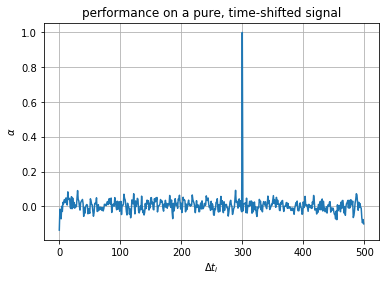

300


In [8]:
# performance on a pure, time-shifted signal
alpha = nndecon(s1,s2,method='ridge',lam=0.00)
plt.plot(alpha)
plt.title('performance on a pure, time-shifted signal')
plt.xlabel('$\\Delta t_i$')
plt.ylabel('$\\alpha$')
plt.grid()
plt.show()
print(abs(alpha).argmax())

In [9]:
# looking at the effect of noise on model performance
# note that both pink and white noise are added
e = np.random.rand(len(s2)) + voss(len(s2))
s2e = s2+e/4
s2e = s2e-sum(s2e)/len(s2e)

C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.044555e-19


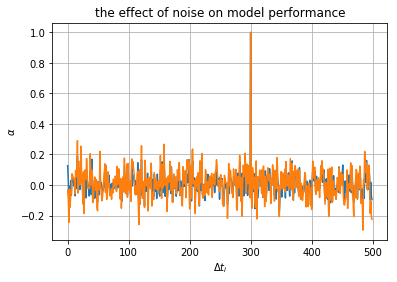

300


In [10]:
alphaE = nndecon(s1,s2e,method='ridge',lam=0)
alphaEW = nndecon(s1,s2e,method='ridge',lam=0,window=True)
plt.plot(alphaE)
plt.plot(alphaEW)
plt.title('the effect of noise on model performance')
plt.xlabel('$\\Delta t_i$')
plt.ylabel('$\\alpha$')
plt.grid()
plt.show()
print(abs(alphaE).argmax())

In [11]:
# a simple diffusion operator from:
# http://hplgit.github.io/num-methods-for-PDEs/doc/pub/diffu/sphinx/._main_diffu001.html
#
# x = data set
# dx = spatial length
# k = diffusion coefficient
# n = number of time steps
# t = total time duration of process
def diffuse(x,k,nt,t):
    dx = 0.01
    dt = t/(nt-1)
    nx = len(x)
    main = np.zeros(nx)
    lower = np.zeros(nx-1)
    upper = np.zeros(nx-1)
    
    K = k*dt/dx**2
    
    main[:] = 1+2*K
    lower[:] = -K
    upper[:] = -K
    # add boundary conditions
    main[0] = 1+K
    main[-1] = 1+K
    
    A = sp.sparse.diags( diagonals=[main,lower,upper],
                           offsets=[0,-1,1], shape=(nx,nx),
                           format='csr')
    
    for n in range(0,nt):
        x = sp.sparse.linalg.spsolve(A,x)
    
    return x

In [12]:
# looking at the effect of diffusion
s2ed = diffuse(s2e,0.01,20,2)
s2d = diffuse(s2,0.01,20,2)
s1d = diffuse(s1,0.01,10,1)

s2ed = s2ed-sum(s2ed)/len(s2ed)
s2d = s2d-sum(s2d)/len(s2d)
s1d = s1d-sum(s1d)/len(s1d)

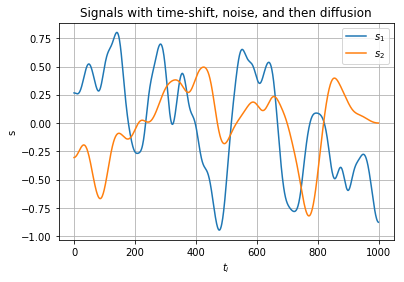

In [13]:
plt.plot(s1d)
plt.plot(s2ed)
plt.title('Signals with time-shift, noise, and then diffusion')
plt.ylabel('s')
plt.xlabel('$t_i$')
plt.legend(['$s_1$','$s_2$'])
plt.grid()

By visual inspection, one might be willing to hazard a guess that the two sigla s are correlated by 30 time steps, but it is non-ovbious. A naive, unregularized solution struggles to find any correlation.

C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.339274e-21
C:\Users\simonk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.345613e-21


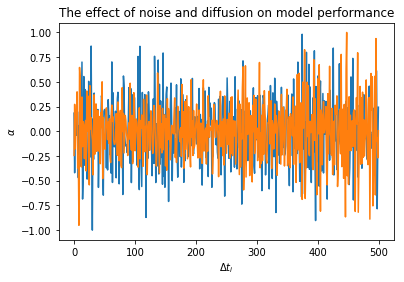

30
447


In [14]:
alphaED = nndecon(s1d,s2ed,lam=0,method='ridge')
alphaEDW = nndecon(s1d,s2ed,lam=0,method='ridge',window=True)
plt.plot(alphaED)
plt.plot(alphaEDW)
plt.title('The effect of noise and diffusion on model performance')
plt.ylabel('$\\alpha$')
plt.xlabel('$\\Delta t_i$')
plt.show()
print(abs(alphaED).argmax())
print(abs(alphaEDW).argmax())

Well that is a total drag. It looks like regularization is necesasry to keep everything from going nuts whenever there is a bit of signal desmearing.

In [15]:
# Ridge Regression
alphaEDR = nndecon(s1d,s2ed,lam=1,method='ridge',window=False)
print(abs(alphaEDR[1:-11]).argmax()+1)

287


In [16]:
# Ridge Regression with windowing
alphaEDWR = nndecon(s1d,s2ed,lam=1,method='ridge',window=True)
print(abs(alphaEDWR[1:-1]).argmax()+1)

293


In [17]:
# lasso regresion
alphaEDL = nndecon(s1d,s2ed,lam=1,method='lasso')
print(abs(alphaEDL[1:-1]).argmax()+1)
#print(alphaEDW.argmax())

494


In [18]:
# Lasso with windowing
alphaEDWL = nndecon(s1d,s2ed,lam=1,method='lasso',window=True)
print(abs(alphaEDWL[1:-1]).argmax()+1)

289


In [19]:
# non negative least squares
alphaEDNN = nndecon(s1d,s2ed,method='nnls')
print(abs(alphaEDNN[1:-1]).argmax()+1)

280


288


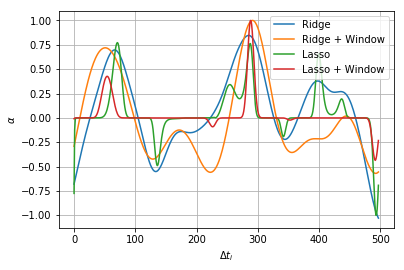

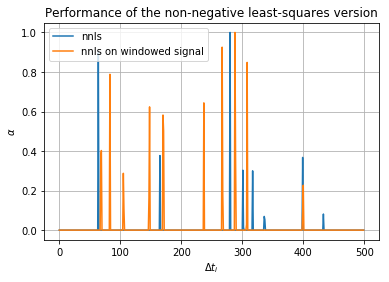

In [20]:
# non negative least squares with windowing
alphaEDWNN = nndecon(s1d,s2ed,method='nnls',window=True)
print(abs(alphaEDWNN[1:-1]).argmax()+1)
plt.plot(alphaEDR[2:])
plt.plot(alphaEDWR[2:])
plt.plot(alphaEDL[1:-1])
plt.plot(alphaEDWL[1:-1])
plt.legend(['Ridge','Ridge + Window',
            'Lasso','Lasso + Window'])
plt.ylabel('$\\alpha$')
plt.xlabel('$\\Delta t_i$')
plt.grid()
plt.show()

plt.title('Performance of the non-negative least-squares version')
plt.ylabel('$\\alpha$')
plt.xlabel('$\\Delta t_i$')
plt.grid(True)
plt.plot(alphaEDNN)
plt.plot(alphaEDWNN)
plt.legend(['nnls','nnls on windowed signal'])
plt.show()

Minimize variation with other data points

In [21]:
# using built-in signal processing tools from python to compute
# the correlation
def fastCorr(s1,s2,show=False):
    FF = sig.correlate(tuple(s2),tuple(s1))
    l = len(s1)
    # assume that we know what direction the time lag will be in
    ff = FF[l:]
    lags = range(0,int(l)-1)
    if show:
        plt.plot(lags,ff/max(ff))
        plt.grid(True)
    return abs(ff).argmax()

In [24]:
# compute the correlated lag between x and y
# xLag is currently expressed in number of time steps
def corrLag(s1,s2,xLag,show=False,window=False):
    n = len(s1)
    if window:
        s = np.dot( windowFun( s2[int(xLag):]   ),
                    windowFun( s1[:int(n-xLag)] ) )    
    else: 
        s = np.dot(s2[int(xLag):],s1[:int(n-xLag)])
    #s = 0
    #for i in range(n-xLag):
    #    s += x[i+xLag]*y[i]
    cov = np.cov([s1,s2])[0,1]
    
    if show:
        plt.scatter(s2[xLag:],s1[:(n-xLag)])
        plt.xlabel('s2')
        plt.ylabel('s1')
    
    # this equation is taken from the 2.131 notes
    return s/cov/(n-xLag)

def corrSweep(x,y,lags,show=False,window=False):
    crossCorr = np.zeros(len(lags))
    for i,lag in enumerate(lags):
        crossCorr[i] = corrLag(x,y,lag,window=window)
    
    if show:
        sign = np.sign( crossCorr[np.argmax(abs(crossCorr))] )
        plt.plot( lags,crossCorr/max(abs(crossCorr))*sign ) 
        plt.xlabel('lag')
        plt.ylabel('Cross-correlation')
        plt.grid(True)
    
    return crossCorr, abs(crossCorr).argmax()

In [35]:
lags = np.arange(0,500)
N = 100
res1 = np.zeros(N)
res2 = np.zeros(N)

# create the simulated signals
samplingRate = 10   # hz
dT = 1/samplingRate # sec
tf = 150
n = tf/dT+1

ts = np.arange(start=0,stop=tf,step=dT)

dt = 300 # We are setting the time delay to be 300 steps
l = 1000
start = 0

w = sig.windows.hann(int(l/2)+1)

#startTime = time.time()

for i,r in enumerate(res1):

    # Create the simulated data sets for the sensor signals
    u = voss(len(ts))
    v = voss(len(ts))
    S1 = u[ (start+dt) : (start+dt+l) ]
    S2 = u[ start:(start+l) ]
    t = ts[ :l]
    
    # compute means and center the data
    S1m = sum(S1)/len(S1)
    S2m = sum(S2)/len(S2)
    #print(S1m)
    #print(S2m)
    s1 = S1-S1m
    #s1t = S1t-S1m
    s2 = S2-S2m
    
    # looking at the effect of noise on model performance
    # note that both pink and white noise are added
    e = np.random.rand(len(s2)) + voss(len(s2))
    s2e = s2+e/5
    s2e = s2e-sum(s2e)/len(s2e)
    
    # looking at the effect of diffusion
    s2ed = diffuse(s2e,0.01,20,2)
    s2d = diffuse(s2,0.01,20,2)
    s1d = diffuse(s1,0.01,10,1)
    s1dw = windowFun(s1d)

    s2ed = s2ed-sum(s2ed)/len(s2ed)
    s2d = s2d-sum(s2d)/len(s2d)
    s1d = s1d-sum(s1d)/len(s1d)
    startTime = time.time()
    ans1 = nndecon(s1d,s2ed,method='nnls',lam=0,window=True,fast=w)
    res2[i] = corrSweep(s1d,s2d,lags,window=True)[1]
    #print( (time.time()-startTime) )
    #plt.plot(ans1)
    res1[i] = ans1.argmax()
    #res2[i] = ans2.argmax()

    startTime = time.time()

(290, 310)

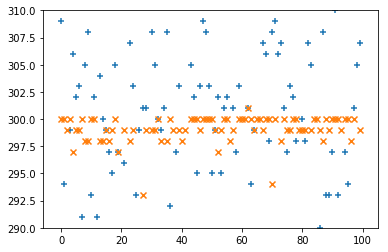

In [36]:
plt.scatter(range(N),res1,marker='+')
plt.scatter(range(N),res2,marker='x')
plt.ylim(290,310)

nonnegative deconvolution outperforms with modest noise, but correlate handles large amounts of noise much better.